<a href="https://colab.research.google.com/github/lamld203844/Biomedical-Image-Processing/blob/main/baseline_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap: EDA
- 78 Video:
  - 6254 frame images
  - 6247 mask images
  - 6224 mask enhance images
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
# Google colab
from google.colab import drive
drive.mount('/content/drive')

# Kaggle

# Local

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install watermark

In [3]:
%load_ext watermark
%watermark -v -p pandas,numoy,matplotlib,seaborn,torch,torchvision,PIL,cv2

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.23.5
pandas     : 1.5.3
matplotlib : 3.7.1
seaborn    : 0.12.2
torch      : 2.1.0+cu121
torchvision: 0.16.0+cu121



In [4]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2

# Prepare dataset

In [5]:
# check the number of frame images and mask

# Path to dataset
dataset_path = "/content/drive/MyDrive/segmentation/us_data/"

img_paths = []
img_mask_paths = []
# img_mask_enhance_paths = []

for vid in os.listdir(dataset_path):
    imgs_path = os.path.join(dataset_path, vid, 'image')
    masks_path = os.path.join(dataset_path, vid, 'mask')
    enhance_masks_path = os.path.join(dataset_path, vid, 'mask_enhance')

    for filename in os.listdir(imgs_path):
      img_path = os.path.join(imgs_path, filename)
      if os.path.isfile(img_path):
        img_paths.append(img_path)

    for filename in os.listdir(masks_path):
      mask_path = os.path.join(masks_path, filename)
      if os.path.isfile(mask_path):
        img_mask_paths.append(mask_path)

    # for filename in os.listdir(enhance_masks_path):
    #   enhance_mask_path = os.path.join(enhance_masks_path, filename)
    #   if os.path.isfile(enhance_mask_path):
    #     img_mask_enhance_paths.append(enhance_mask_path)

print(f'{len(img_paths)} frame images')
print(f'{len(img_mask_paths)} mask images')
# print(f'{len(img_mask_enhance_paths)} mask enhance images')

6254 frame images
6247 mask images


In [6]:
# 6254 image != 6247 mask >> Need mapping 1-1
imgs = [img.replace("_mask", "").replace("mask", "image") for img in img_mask_paths]

## Define dataset
- load images and masks, apply transformations, and return them as a dictionary

In [7]:
print(len(imgs))
print(len(img_mask_paths))

6247
6247


In [8]:
from sklearn.model_selection import train_test_split

train_img_dir, test_img_dir, train_mask_dir, test_mask_dir = train_test_split(imgs, img_mask_paths, test_size = 0.1, random_state=123)
train_img_dir, val_img_dir, train_mask_dir, val_mask_dir = train_test_split(train_img_dir, train_mask_dir, test_size = 0.1, random_state=123)

In [9]:
print(len(train_img_dir))
print(len(test_img_dir))
print(len(val_img_dir))

5059
625
563


In [10]:
# [os.path.basename(filename).split('.')[0] for filename in imgs if filename.endswith(".png")]
os.path.basename(imgs[0]).split('.')

['20190830T115644_629', 'png']

#### Define dataset class

In [11]:
# define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = [os.path.basename(filename).split('.')[0] for filename in image_dir if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]

        image_path = self.image_dir[idx]
        image = Image.open(image_path)

        mask_path = self.mask_dir[idx]
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to appropriate format (e.g., LongTensor for binary segmentation)
        # mask = torch.as_tensor(mask, dtype=torch.long)

        return image, mask

In [12]:
transform = transforms.Compose([
    transforms.CenterCrop((1024, 1024)),
    transforms.ToTensor(),
])

#### Define dataset instance

In [13]:
train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = SegmentationDataset(val_img_dir, val_mask_dir, transform=transform)
test_dataset = SegmentationDataset(test_img_dir, test_mask_dir, transform=transform)

#### Instantiate dataloaders


In [14]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

#### Test dataloaders

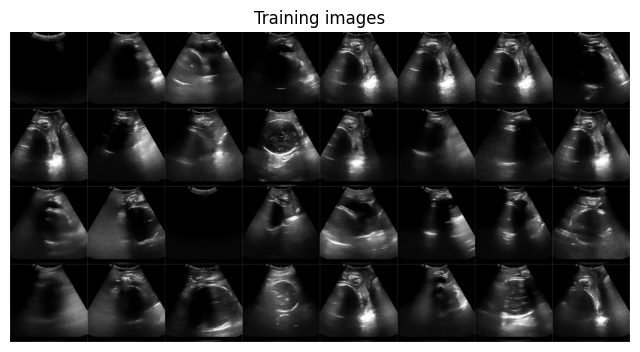

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_dataloader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:32],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

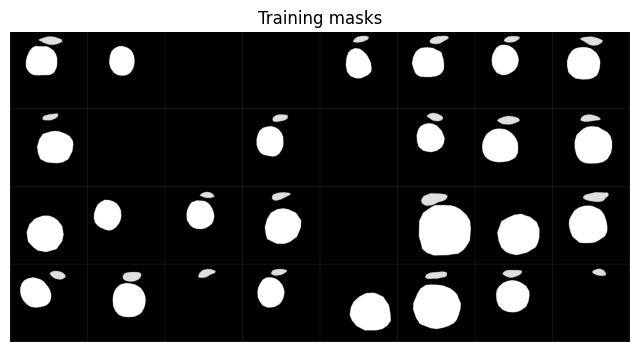

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, masks in train_dataloader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training masks")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    masks[:32],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()